### Import libraries

In [1]:
import kaos
import numpy as np
import pandas as pd
from Bio import SeqIO
import time
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
import requests
import tensorflow as tf
from keras.layers import Dense, LeakyReLU
from keras.initializers import he_normal
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import Precision, Recall
from keras.utils import to_categorical
import itertools
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score, confusion_matrix

### Generate R kaos 'FCGR' embedding in python(https://doi.org/10.1093/bioinformatics/btab681)


In [2]:
kaosr = importr('kaos')
seqinr = importr('seqinr')

def return_r_character_array(python_string):
    
    import rpy2.robjects as robjects

    r_char_array = robjects.StrVector(list(python_string))

    return r_char_array

def kaos_r(sequence, k):
    import time
    dna_array = return_r_character_array(sequence)
    start_time = time.time()
    x_cgr = kaosr.cgr(dna_array, res=k)
    end_time = time.time()
    print("Time taken in R: " + str(np.round((end_time - start_time),3)))

    return np.array(x_cgr.rx2('matrix')), np.round((end_time - start_time),3)

### Load the Data

In [3]:
df = pd.read_csv("example_data.csv")
df_label = pd.read_csv("example_pheno.csv")

In [4]:
df["ref"] = ""

In [ ]:
df

#### Decoding 'N', 'A', 'G', 'C' and 'T' with '0', '1', '2', '3' respectively 

In [5]:
df = df.replace({0: 'N', 1: 'A', 2: 'G', 3: 'C', 4: 'T'})
df

,393,588,747,759,774,966,1299,1302,1407,1425,...,4640908,4640924,4641031,4641131,4641208,4641217,4641296,4641439,4641440,ref
0,G,A,G,T,C,C,C,C,T,G,...,T,G,A,C,T,A,C,C,A,
1,G,A,G,T,C,C,C,C,T,G,...,T,G,A,C,T,A,C,C,A,
2,G,A,G,T,C,C,N,N,T,G,...,T,G,A,C,T,A,C,C,A,
3,G,A,G,T,C,C,C,C,T,G,...,T,G,A,C,A,A,C,C,A,
4,N,N,G,T,C,C,C,C,T,G,...,N,N,G,C,T,A,C,C,A,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,N,N,G,T,C,C,N,N,T,N,...,N,N,G,C,T,A,C,C,A,
896,G,A,G,T,C,C,C,C,T,G,...,T,G,A,C,T,A,C,C,A,
897,G,A,G,T,C,C,C,C,T,G,...,T,G,A,C,T,A,C,C,A,
898,G,N,N,N,C,N,C,C,T,N,...,N,N,N,C,N,N,N,N,N,


### Concatenation of all the elements in each row converted to strings and write in 'ref' column

In [6]:
df["ref"] = df.apply(lambda row: ''.join(map(str, row)), axis=1)

In [ ]:
df

In [7]:
lst = list()

for i in range(df.shape[0]):

    lst.append(kaos_r(df.loc[i, "ref"], k=200)[0])
    # break

Time taken in R: 1.204
Time taken in R: 1.441
Time taken in R: 0.771
Time taken in R: 0.926
Time taken in R: 0.772
Time taken in R: 1.0
Time taken in R: 0.74
Time taken in R: 0.75
Time taken in R: 0.941
Time taken in R: 0.875
Time taken in R: 0.807
Time taken in R: 0.781
Time taken in R: 0.691
Time taken in R: 0.645
Time taken in R: 0.65
Time taken in R: 0.668
Time taken in R: 0.647
Time taken in R: 0.659
Time taken in R: 0.67
Time taken in R: 0.638
Time taken in R: 0.714
Time taken in R: 0.65
Time taken in R: 0.641
Time taken in R: 0.634
Time taken in R: 0.665
Time taken in R: 0.643
Time taken in R: 0.645
Time taken in R: 0.651
Time taken in R: 0.65
Time taken in R: 0.656
Time taken in R: 0.66
Time taken in R: 0.641
Time taken in R: 0.66
Time taken in R: 0.641
Time taken in R: 0.662
Time taken in R: 0.737
Time taken in R: 0.631
Time taken in R: 0.644
Time taken in R: 0.683
Time taken in R: 0.655
Time taken in R: 0.638
Time taken in R: 0.642
Time taken in R: 0.642
Time taken in R: 0.64

In [ ]:
lst[0]

### Read the 'y' labels

In [8]:
y = df_label["CIP"]
targets = to_categorical(y)

### Split data into 'train' and 'test' set

In [9]:
X_train, X_test, y_train, y_test = train_test_split(np.array(lst), targets, test_size=0.2, stratify= y, random_state= 123)

In [ ]:
X_train.shape

In [ ]:
X_test.shape

In [ ]:
def custom_tuned():
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(MaxPooling1D(pool_size=4))
    model.add(Conv1D(filters=128, kernel_size=3))
    model.add(MaxPooling1D(pool_size=8))
    # model.add(Dropout(0.2))
    model.add(Flatten())
    # model.add(Dense(128, activation=LeakyReLU(alpha=0.01),kernel_initializer=he_normal(seed=0)))
    model.add(Dropout(0.2))
    model.add(Dense(256, kernel_regularizer=tf.keras.regularizers.L2(0.001)))
    model.add(Dense(2, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy', 'Precision', 'Recall'])
    # model.summary()

    return model

In [ ]:
model_r_hypertunned = custom_tuned()
model_r_hypertunned.summary()

In [ ]:
model_r_package =  r_kaos_package_model()
model_r_package.summary()

### Define model and other parameters

In [ ]:
model = Sequential()
model.add(Conv1D(filters=8, kernel_size=3,activation='relu', input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(BatchNormalization())
model.add(Conv1D(filters=8, kernel_size=3, padding='same', activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(2)))
model.add(Conv1D(filters=16, kernel_size=3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(filters=16, kernel_size=3, padding='same', activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2,activation='softmax'))
# Compile the model
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics= ['accuracy', 'Precision', 'Recall'])
model.summary()

### R Kaos Original model

### Define model and other parameters

In [10]:
def r_kaos_package_model():

    model = Sequential()
    model.add(Conv1D(filters=8, kernel_size=3,activation='relu', input_shape=(X_train.shape[1],X_train.shape[2])))
    model.add(BatchNormalization())
    model.add(Conv1D(filters=8, kernel_size=3, padding='same', activation='relu'))
    #model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=(2)))
    model.add(Conv1D(filters=16, kernel_size=3, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv1D(filters=16, kernel_size=3, padding='same', activation='relu'))
    #model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=(2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(2,activation='softmax'))
    # Compile the model
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics= ['accuracy', 'Precision', 'Recall'])
    # model.summary()

    return model

In [11]:
model_r_package =  r_kaos_package_model()
model_r_package.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 198, 8)            4808      
                                                                 
 batch_normalization (Batch  (None, 198, 8)            32        
 Normalization)                                                  
                                                                 
 conv1d_1 (Conv1D)           (None, 198, 8)            200       
                                                                 
 max_pooling1d (MaxPooling1  (None, 99, 8)             0         
 D)                                                              
                                                                 
 conv1d_2 (Conv1D)           (None, 99, 16)            400       
                                                                 
 batch_normalization_1 (Bat  (None, 99, 16)            6

### Train the model

In [12]:
history = model_r_package.fit(X_train, y_train, epochs=500, verbose=1, validation_split=0.2, batch_size=1500)

Epoch 1/500
1/1 [==============================] - 9s 9s/step - loss: 1.3780 - accuracy: 0.5486 - precision: 0.5486 - recall: 0.5486 - val_loss: 1.4166 - val_accuracy: 0.4167 - val_precision: 0.4167 - val_recall: 0.4167
Epoch 2/500
1/1 [==============================] - 1s 686ms/step - loss: 0.7718 - accuracy: 0.4531 - precision: 0.4531 - recall: 0.4531 - val_loss: 0.8391 - val_accuracy: 0.5139 - val_precision: 0.5139 - val_recall: 0.5139
Epoch 3/500
1/1 [==============================] - 1s 620ms/step - loss: 0.8030 - accuracy: 0.4792 - precision: 0.4792 - recall: 0.4792 - val_loss: 0.9021 - val_accuracy: 0.5139 - val_precision: 0.5139 - val_recall: 0.5139
Epoch 4/500
1/1 [==============================] - 1s 753ms/step - loss: 0.8100 - accuracy: 0.6337 - precision: 0.6337 - recall: 0.6337 - val_loss: 0.8724 - val_accuracy: 0.5139 - val_precision: 0.5139 - val_recall: 0.5139
Epoch 5/500
1/1 [==============================] - 1s 623ms/step - loss: 0.7841 - accuracy: 0.5938 - precision:

### Plot loss-matric curve and accuracy curve

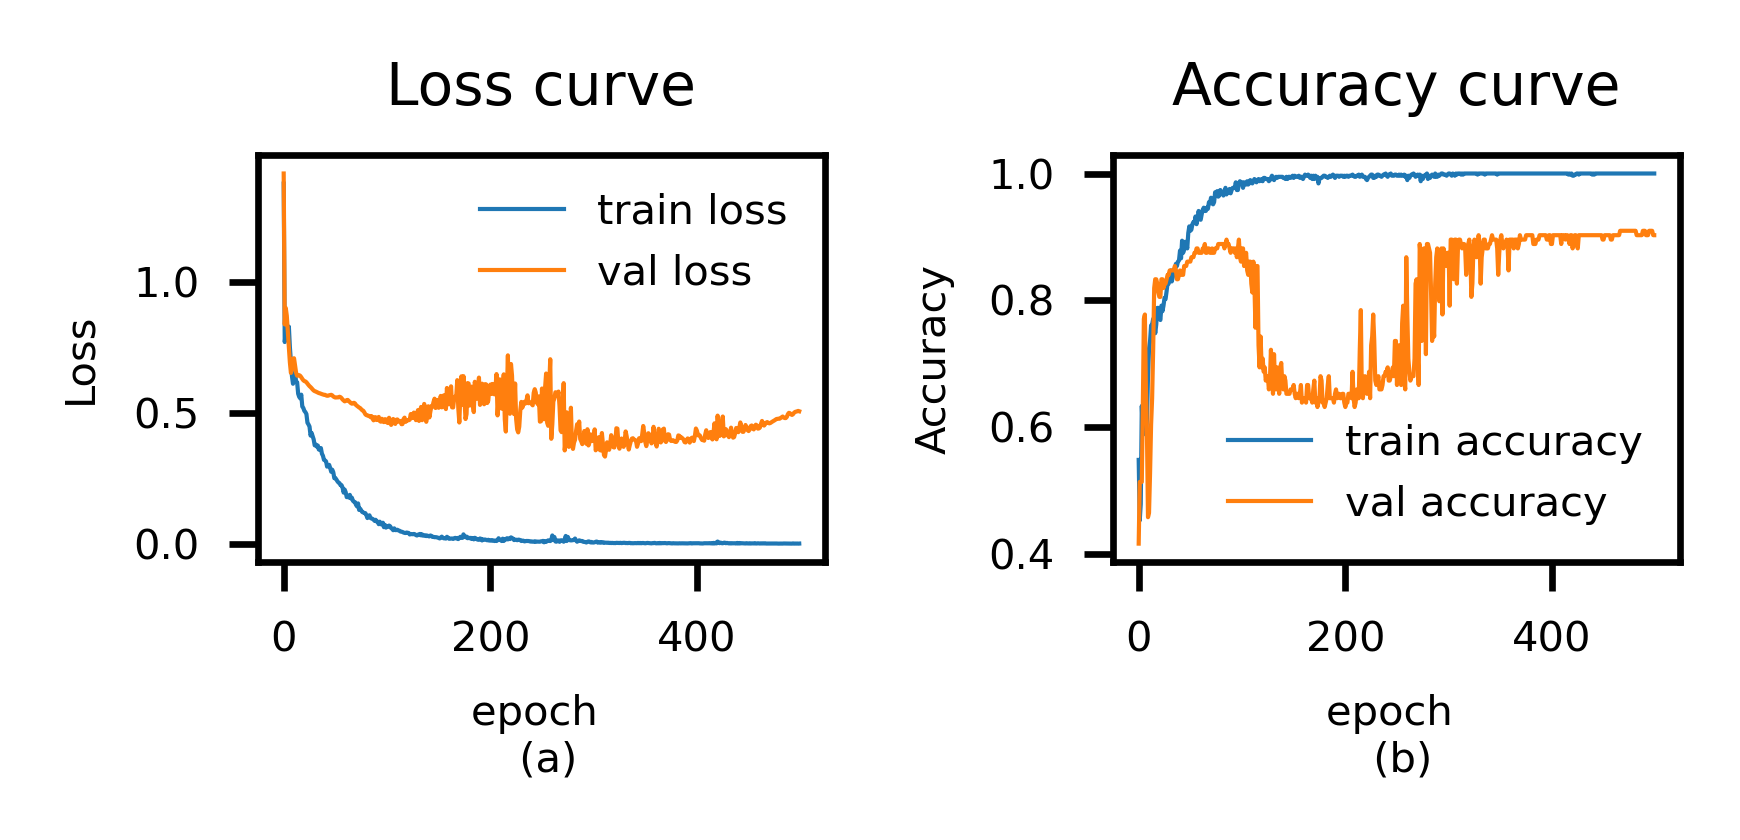

In [13]:
fig, ax= plt.subplots(1, 2, dpi =600, figsize = (3, 1.5))
ax[0].plot(history.history['loss'], label = "train loss", lw = 0.5)
ax[0].plot(history.history['val_loss'], label = "val loss", lw = 0.5)
ax[1].plot(history.history['accuracy'], label = "train accuracy", lw = 0.5)
ax[1].plot(history.history['val_accuracy'], label = "val accuracy", lw = 0.5)
ax[0].legend(fontsize=5, frameon=False)
ax[1].legend(fontsize=5, frameon=False)
ax[0].set_title("Loss curve", fontsize=7)
ax[1].set_title("Accuracy curve", fontsize=7)
ax[0].set_xlabel("epoch \n (a)", fontsize=5)
ax[1].set_xlabel("epoch \n (b)", fontsize=5)
ax[0].set_ylabel("Loss", fontsize=5)
ax[1].set_ylabel("Accuracy", fontsize=5)
ax[0].tick_params(axis='both', which='major', labelsize=5)
ax[1].tick_params(axis='both', which='major', labelsize=5)
# ax[0] = custom_figure_axis(ax[0], fontsize=5, show_ticks = True)
# ax[1] = custom_figure_axis(ax[1], fontsize=5, show_ticks = True)
# plt.title('R.Kaos_Original model')
plt.tight_layout()
# plt.savefig("Motif curve.pdf", dpi = 600)

### Normalized confusion matrix

6/6 [==============================] - 0s 6ms/step
Confusion matrix:
 [[87 16]
 [ 9 68]]


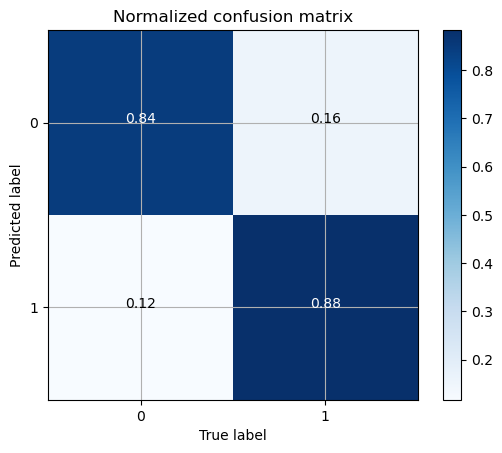

In [16]:
predicted_labels = model_r_package.predict(X_test)
cm = confusion_matrix(np.argmax(predicted_labels, axis=1), np.argmax(y_test, axis = 1))
print('Confusion matrix:\n',cm)

cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Normalized confusion matrix')
plt.colorbar()
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.xticks([0, 1]); plt.yticks([0, 1])
plt.grid('off')
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment='center',
             color='white' if cm[i, j] >= 0.5 else 'black')

### Matric result

In [17]:
print("The accuracy of test set is ", accuracy_score(np.argmax(predicted_labels, axis=1), np.argmax(y_test, axis = 1)))
print("The precision of test set is ",  precision_score(np.argmax(predicted_labels, axis=1), np.argmax(y_test, axis = 1)))
print("The recall of test set is ", recall_score(np.argmax(predicted_labels, axis=1), np.argmax(y_test, axis = 1)))
print("The f1 of test set is ",  f1_score(np.argmax(predicted_labels, axis=1), np.argmax(y_test, axis = 1)))
print("The ROC_AUC of test set is ", roc_auc_score(np.argmax(predicted_labels, axis=1), np.argmax(y_test, axis = 1)))
print("The cohen kappa of test set is ", cohen_kappa_score(np.argmax(predicted_labels, axis=1), np.argmax(y_test, axis = 1)))


The accuracy of test set is  0.8611111111111112
The precision of test set is  0.8095238095238095
The recall of test set is  0.8831168831168831
The f1 of test set is  0.84472049689441
The ROC_AUC of test set is  0.8638885386458202
The cohen kappa of test set is  0.7195213163799552


### Hypertuned model

### Define the model

In [18]:
def custom_tuned():
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(MaxPooling1D(pool_size=4))
    model.add(Conv1D(filters=128, kernel_size=3))
    model.add(MaxPooling1D(pool_size=8))
    # model.add(Dropout(0.2))
    model.add(Flatten())
    # model.add(Dense(128, activation=LeakyReLU(alpha=0.01),kernel_initializer=he_normal(seed=0)))
    model.add(Dropout(0.2))
    model.add(Dense(256, kernel_regularizer=tf.keras.regularizers.L2(0.001)))
    model.add(Dense(2, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy', 'Precision', 'Recall'])
    # model.summary()

    return model

In [19]:
model_r_hypertunned = custom_tuned()
model_r_hypertunned.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 198, 64)           38464     
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 49, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_5 (Conv1D)           (None, 47, 128)           24704     
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 5, 128)            0         
 g1D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 640)               0         
                                                                 
 dropout_1 (Dropout)         (None, 640)              

### Train the model

In [20]:
history = model_r_hypertunned.fit(X_train, y_train, epochs=500, verbose=1, validation_split=0.2, batch_size=1500)

Epoch 1/500
1/1 [==============================] - 4s 4s/step - loss: 9.1182 - accuracy: 0.4184 - precision: 0.4184 - recall: 0.4184 - val_loss: 1.7128 - val_accuracy: 0.5903 - val_precision: 0.5903 - val_recall: 0.5903
Epoch 2/500
1/1 [==============================] - 1s 764ms/step - loss: 7.9605 - accuracy: 0.5017 - precision: 0.5017 - recall: 0.5017 - val_loss: 2.9319 - val_accuracy: 0.5903 - val_precision: 0.5903 - val_recall: 0.5903
Epoch 3/500
1/1 [==============================] - 1s 597ms/step - loss: 6.4444 - accuracy: 0.5608 - precision: 0.5608 - recall: 0.5608 - val_loss: 4.4498 - val_accuracy: 0.6111 - val_precision: 0.6111 - val_recall: 0.6111
Epoch 4/500
1/1 [==============================] - 1s 608ms/step - loss: 5.4254 - accuracy: 0.6510 - precision: 0.6510 - recall: 0.6510 - val_loss: 4.3409 - val_accuracy: 0.5972 - val_precision: 0.5972 - val_recall: 0.5972
Epoch 5/500
1/1 [==============================] - 1s 583ms/step - loss: 7.4241 - accuracy: 0.6007 - precision:

### Plot loss-matric curve and accuracy curve

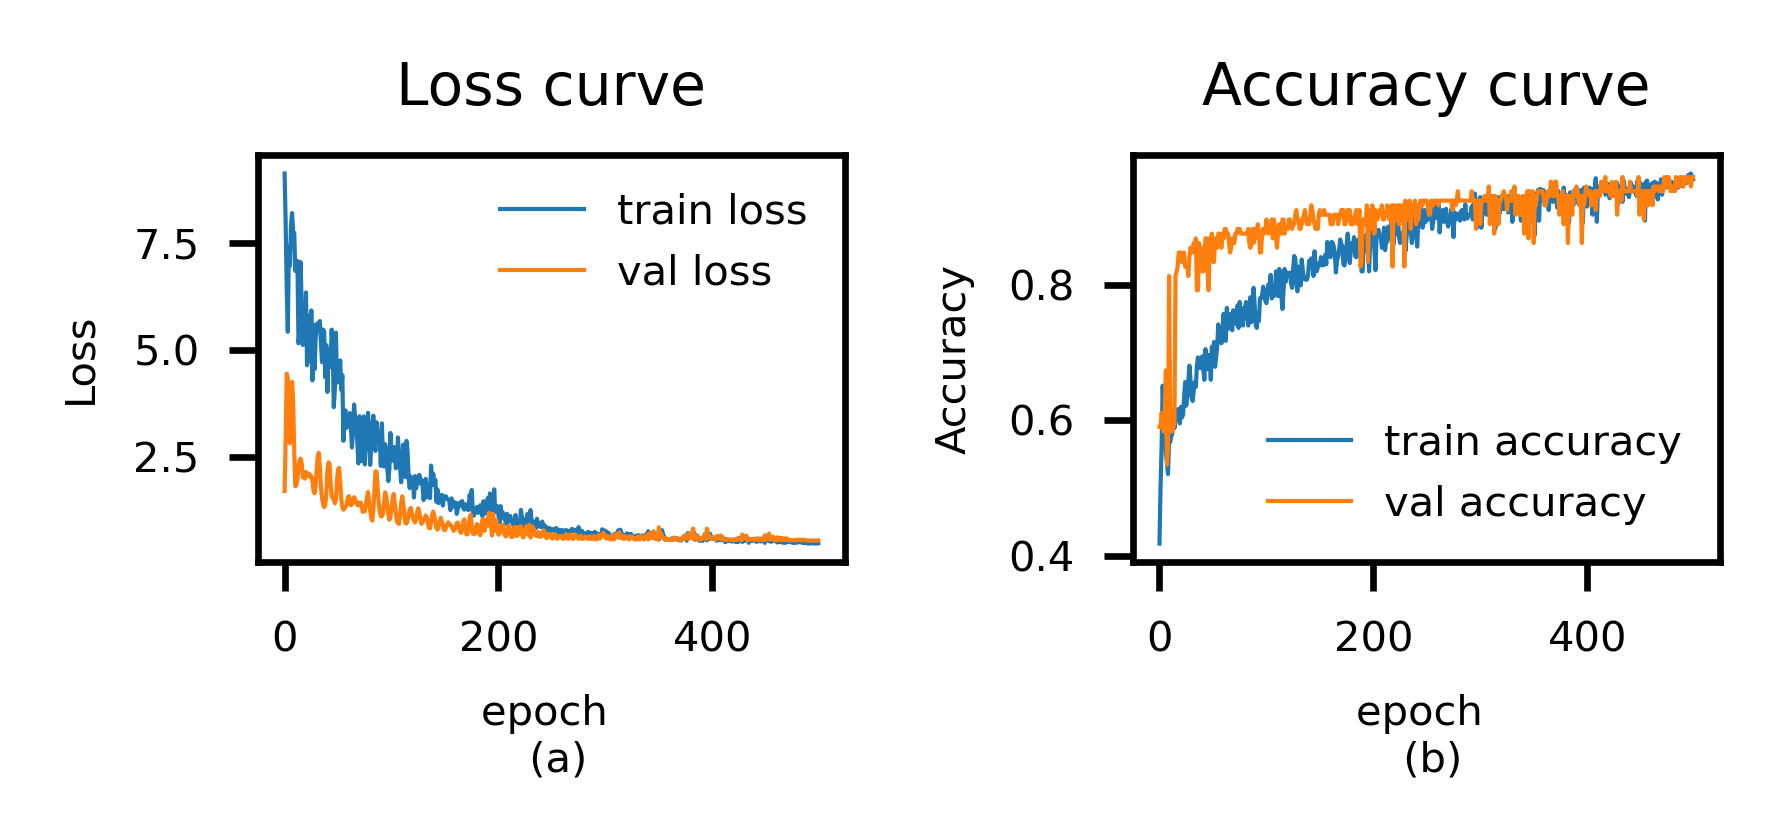

In [21]:
fig, ax= plt.subplots(1, 2, dpi =600, figsize = (3, 1.5))
ax[0].plot(history.history['loss'], label = "train loss", lw = 0.5)
ax[0].plot(history.history['val_loss'], label = "val loss", lw = 0.5)
ax[1].plot(history.history['accuracy'], label = "train accuracy", lw = 0.5)
ax[1].plot(history.history['val_accuracy'], label = "val accuracy", lw = 0.5)
ax[0].legend(fontsize=5, frameon=False)
ax[1].legend(fontsize=5, frameon=False)
ax[0].set_title("Loss curve", fontsize=7)
ax[1].set_title("Accuracy curve", fontsize=7)
ax[0].set_xlabel("epoch \n (a)", fontsize=5)
ax[1].set_xlabel("epoch \n (b)", fontsize=5)
ax[0].set_ylabel("Loss", fontsize=5)
ax[1].set_ylabel("Accuracy", fontsize=5)
ax[0].tick_params(axis='both', which='major', labelsize=5)
ax[1].tick_params(axis='both', which='major', labelsize=5)
# ax[0] = custom_figure_axis(ax[0], fontsize=5, show_ticks = True)
# ax[1] = custom_figure_axis(ax[1], fontsize=5, show_ticks = True)
# plt.title('R.Kaos_Original model')
plt.tight_layout()
# plt.savefig("Motif curve.pdf", dpi = 600)

### Normalized confusion matrix

6/6 [==============================] - 0s 10ms/step
Confusion matrix:
 [[89 11]
 [ 7 73]]


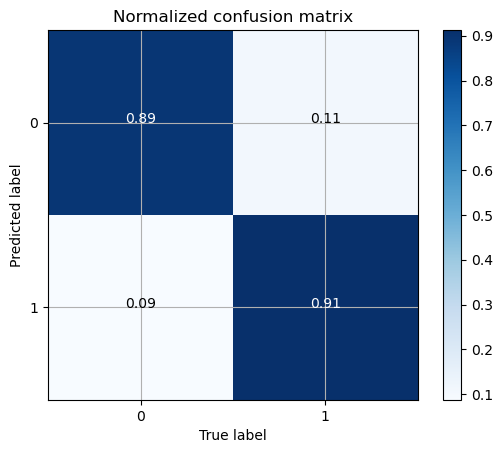

In [22]:
predicted_labels = model_r_hypertunned.predict(X_test)
cm = confusion_matrix(np.argmax(predicted_labels, axis=1), np.argmax(y_test, axis = 1))
print('Confusion matrix:\n',cm)

cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Normalized confusion matrix')
plt.colorbar()
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.xticks([0, 1]); plt.yticks([0, 1])
plt.grid('off')
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment='center',
             color='white' if cm[i, j] >= 0.5 else 'black')

### Matric result

In [23]:
print("The accuracy of test set is ", accuracy_score(np.argmax(predicted_labels, axis=1), np.argmax(y_test, axis = 1)))
print("The precision of test set is ",  precision_score(np.argmax(predicted_labels, axis=1), np.argmax(y_test, axis = 1)))
print("The recall of test set is ", recall_score(np.argmax(predicted_labels, axis=1), np.argmax(y_test, axis = 1)))
print("The f1 of test set is ",  f1_score(np.argmax(predicted_labels, axis=1), np.argmax(y_test, axis = 1)))
print("The ROC_AUC of test set is ", roc_auc_score(np.argmax(predicted_labels, axis=1), np.argmax(y_test, axis = 1)))
print("The cohen kappa of test set is ", cohen_kappa_score(np.argmax(predicted_labels, axis=1), np.argmax(y_test, axis = 1)))


The accuracy of test set is  0.9
The precision of test set is  0.8690476190476191
The recall of test set is  0.9125
The f1 of test set is  0.8902439024390244
The ROC_AUC of test set is  0.9012500000000001
The cohen kappa of test set is  0.7985074626865671


In [ ]:
dna_array = return_r_character_array(df.loc[0, "ref"])
dna_array

In [ ]:
x_cgr = kaosr.cgr(dna_array, res=10)

In [ ]:
np.array(x_cgr.rx2('matrix')).shape

In [ ]:
lst[0][0].shape